<a href="https://colab.research.google.com/github/DivaldoJr1001/MBACienciaDeDados-Python-WebScraping/blob/main/MBACienciaDeDados-Python-WebScraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://www.unifor.br/o/unifor-theme/images/unifor-logo-horizontal.svg' width="250px">

# MBA em Ciência de Dados - Universidade de Fortaleza

## Data Harvesting - Projeto de Disciplina

### Prof. Ms. Alex Lima

#### <b>(Março/2025)</b>

-------------------------

### <b>Aluno:</b> Divaldo Aderaldo de Oliveira Júnior (2419413)<br>

### Scraping de dados e comparação de preços em múltiplos sites com base em uma string de pesquisa.

# Instalação de Requisitos

In [18]:
!apt-get update
!apt-get install -y wget unzip
!wget -q https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb || true
!apt-get -f install -y
!wget -q https://chromedriver.storage.googleapis.com/$(curl -sS https://chromedriver.storage.googleapis.com/LATEST_RELEASE)/chromedriver_linux64.zip
!unzip -o chromedriver_linux64.zip
!chmod +x chromedriver
!mv chromedriver /usr/local/bin/
!pip install -U selenium webdriver-manager

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://dl.google.com/linux/chrome/deb stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading

# Configuração Inicial

In [19]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

In [20]:
def get_driver():
  options = webdriver.ChromeOptions()
  options.add_argument('--headless')
  options.add_argument('--no-sandbox')
  options.add_argument('--disable-dev-shm-usage')
  options.add_argument('--disable-blink-features=AutomationControlled')
  options.add_argument("--window-size=1920,1080")
  options.add_argument('--lang=en-US,en;q=0.9')
  options.add_argument('--referer=https://www.google.com/')

  options.add_argument('--disable-gpu')
  options.add_argument('--disable-infobars')
  options.add_argument('--disable-extensions')
  options.add_argument('--disable-logging')
  options.add_argument('--disable-notifications')
  options.add_argument('--disable-popup-blocking')

  options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36')
  options.add_argument('--blink-settings=imagesEnabled=false')

  service = Service(ChromeDriverManager().install())
  driver = webdriver.Chrome(service=service, options=options)

  return driver

# Escolha de Produto

In [21]:
produto_a_pesquisar = 'iPhone 15'

# Funções de Scraping

## Importações

In [22]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import pandas as pd
import numpy as np
import time

## Filtragem de Outliers

In [23]:
def filter_dataframe(df):
    if df.empty or 'Preço' not in df.columns:
        return df

    threshold = np.max(df['Preço']) / 3

    df_filtered = df[df['Preço'] >= threshold]
    return df_filtered

## Scraper Genérico

In [24]:
def scraper(
    store,
    website_link,
    query,
    spacer,
    product_item_class,
    product_name_class,
    product_price_class,
    suppress_errors=False,
    show_progress=False,
    save_html=False,
    show_link=False):
  driver = get_driver()

  link = website_link.replace("[query]", query.replace(' ', spacer))

  if show_link:
    print(link)

  driver.get(link)

  try:
    if save_html:
      file_name = f"pagina-{store.replace(' ', '_')}.html"
      with open(file_name, 'w', encoding='utf-8') as f:
          f.write(driver.page_source)
      print(f'HTML salvo em {file_name}')

    if "captcha" in driver.page_source.lower():
      print("Captcha detectado. Interrompendo scraping.")
      driver.quit()
      return pd.DataFrame()

    WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.CLASS_NAME, product_item_class))
    )
  except Exception as e:
    print(f"Erro ao carregar a página de {store}: {e}")
    driver.quit()
    return pd.DataFrame()

  last_height = driver.execute_script("return document.body.scrollHeight")
  while True:
      driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
      time.sleep(2)
      new_height = driver.execute_script("return document.body.scrollHeight")
      if new_height == last_height:
          break
      last_height = new_height

  produtos = []
  items = driver.find_elements(By.CLASS_NAME, product_item_class)

  for item in items:
      try:
          nome = item.find_element(By.CLASS_NAME, product_name_class).text

          if show_progress:
            print(f"Nome: {nome}")

          price_element = item.find_element(By.CLASS_NAME, product_price_class)

          preco = price_element.text.strip()

          preco_partes = preco.split('R$')

          preco = preco_partes[-1].strip()

          preco = preco.split(' ')[0]

          preco = preco.replace('.', '').replace(',', '.')

          preco = float(preco)

          if show_progress:
            print(f"Preço: {preco}")

          produtos.append({'Nome': nome, 'Preço': preco})
      except Exception as e:
        if not suppress_errors:
          print(f"Erro ao coletar item: {e}")
        continue
  df = pd.DataFrame(produtos)
  df['Plataforma'] = store
  df = filter_dataframe(df)

  driver.quit()

  return df

## Mercado Livre

In [25]:
df_mercado_livre = scraper(
    "Mercado Livre",
    "https://lista.mercadolivre.com.br/[query]",
    produto_a_pesquisar,
    "-",
    "ui-search-layout__item",
    "poly-component__title",
    "andes-money-amount__fraction"
)

## Kabum

In [26]:
df_kabum = scraper(
    "Kabum",
    "https://www.kabum.com.br/busca/[query]",
    produto_a_pesquisar,
    "%20",
    "productCard",
    "nameCard",
    "priceCard"
)

## Horizon Play

In [27]:
df_horizon_play = scraper(
    "Horizon Play",
    "https://www.horizonplay.com.br/busca?busca=[query]",
    produto_a_pesquisar,
    "+",
    "spot-list_item",
    "spot-title",
    "product-price_value"
)

## XonGeek

In [28]:
df_xongeek = scraper(
    "XonGeek",
    "https://www.xongeek.com.br/buscar?q=[query]",
    produto_a_pesquisar,
    "+",
    "listagem-item",
    "nome-produto",
    "preco-produto",
    suppress_errors=True
)

## Bne Store

In [29]:
df_bne_store = scraper(
    "Bne Store",
    "https://www.bnestore.com.br/loja/busca.php?loja=1324137&palavra_busca=[query]&order=0&categoria=",
    produto_a_pesquisar.lower(),
    "+",
    "product",
    "product-name",
    "current-price",
    suppress_errors=True
)

## Concatenação

In [30]:
df_dados = pd.concat([df_mercado_livre, df_kabum, df_horizon_play, df_xongeek, df_bne_store], ignore_index=True)
df_dados = filter_dataframe(df_dados)

# Visualização de Grafo

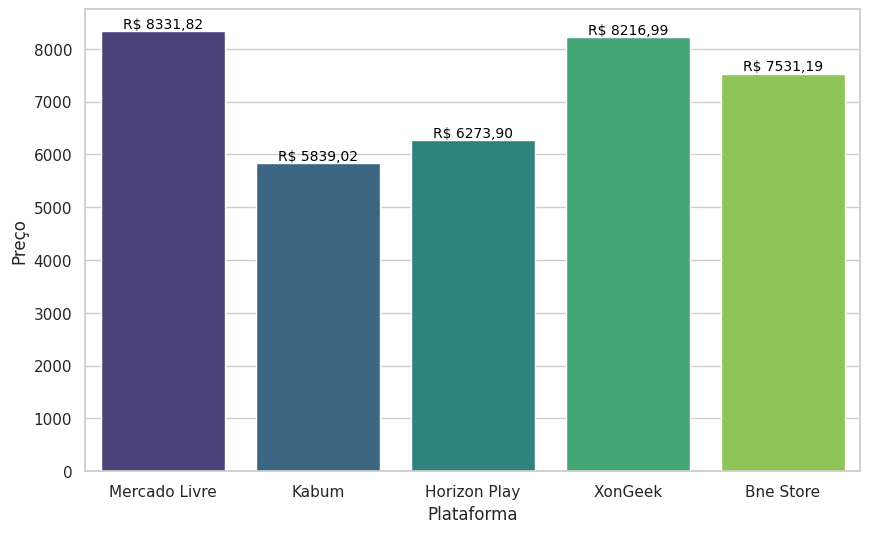

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x='Plataforma',
    y='Preço',
    data=df_dados,
    estimator=np.mean,
    errorbar=None,
    palette='viridis',
    hue='Plataforma',
    legend=False
)

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2.,
        p.get_height(),
        f'R$ {p.get_height():.2f}'.replace('.', ','),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.title(f"Comparativo de Preços - {produto_a_pesquisar}")
plt.xlabel('Plataforma')
plt.ylabel('Preço (R$)')
plt.show()